In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


In [3]:
param = [[3, 64, 11, 0, 4], [64, 192, 5, 2, 1], [192, 2, 3, 1, 1]]  # in_channels, out_channels, kernel_size, padding, stride

In [4]:
class NiN(nn.Module):
    def __init__(self, param, num_classes):
        super(NiN, self).__init__()
        self.features1 = self.nin_block(param[0])
        self.features2 = self.nin_block(param[1])
        self.features3 = self.nin_block(param[2])

    def nin_block(self, a_param):
        layers = []

        layers.append(nn.Conv2d(in_channels=a_param[0], out_channels=a_param[1], kernel_size=a_param[2], padding=a_param[3], stride=a_param[4]))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=a_param[1], out_channels=a_param[1], kernel_size=1, padding=1))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=a_param[1], out_channels=a_param[1], kernel_size=1, padding=1))
        layers.append(nn.ReLU(inplace=True))

        return nn.Sequential(*layers)       

    def forward(self, x):
        x = self.features1(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.features2(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = self.features3(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, start_dim=1)

        return x


In [6]:
# Parameters
batch_size = 128
num_epochs = 5
lr = 0.001

num_classes=2
model = NiN(param, num_classes)

if CUDA:
    model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [7]:
import json
import zipfile
import os

# kaggle api
api_token = {"username":"aaa","key":"kkk"}
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d chetankv/dogs-cats-images --force
 
!ls /kaggle

100% 433M/435M [00:09<00:00, 59.9MB/s]
100% 435M/435M [00:09<00:00, 47.3MB/s]
dogs-cats-images.zip


In [8]:
!unzip dogs-cats-images.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3710.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3711.jpg  
  inflating: dog vs cat/dataset/training_set/cats/cat.3712.jpg  
  infl

In [9]:
# Transform
transform = transforms.Compose(
                [transforms.Resize(size=(227,227)),
                 transforms.CenterCrop(224),
                 transforms.RandomRotation(20),
                  transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),]
                )

# Data
train_dataset = datasets.ImageFolder(root='/kaggle/dataset/training_set', transform=transform)
valid_dataset = datasets.ImageFolder(root='/kaggle/dataset/test_set', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    total_train = 0
    correct_train = 0
    train_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        # clear gradient
        optimizer.zero_grad()

        # Forward propagation
        output = model(data) 
        loss = criterion(output, target) 

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += sum((predicted == target).float())
        train_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Train Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(train_loader),
               correct_train / float((batch_idx + 1) * batch_size),
               train_loss / float((batch_idx + 1) * batch_size)))
            
    train_acc_ = 100 * (correct_train / float(total_train))
    train_loss_ = train_loss / total_train
                    
    return train_acc_, train_loss_

In [11]:
def validate(valid_loader, model, criterion, epoch): 
    model.eval()
    total_valid = 0
    correct_valid = 0
    valid_loss = 0
    
    for batch_idx, (data, target) in enumerate(valid_loader):
        data, target = Variable(data), Variable(target) 
        
        if CUDA:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        loss = criterion(output, target) 

        predicted = torch.max(output.data, 1)[1]
        total_valid += len(target)
        correct_valid += sum((predicted == target).float())
        valid_loss += loss.item()

        if batch_idx % 100 == 0:
            print("Valid Epoch: {}/{} [iter： {}/{}], acc： {:.6f}, loss： {:.6f}".format(
               epoch+1, num_epochs, batch_idx+1, len(valid_loader),
               correct_valid / float((batch_idx + 1) * batch_size),
               valid_loss / float((batch_idx + 1) * batch_size)))
            
    valid_acc_ = 100 * (correct_valid / float(total_valid))
    valid_loss_ = valid_loss / total_valid
                    
    return valid_acc_, valid_loss_

In [12]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader):
    # set objects for storing metrics
    total_train_loss = []
    total_valid_loss = []
    total_train_accuracy = []
    total_valid_accuracy = []
 
    # Train model
    for epoch in range(num_epochs):
        # training
        train_acc_, train_loss_ = train(train_loader, model, criterion, optimizer, epoch)
        total_train_loss.append(train_loss_)
        total_train_accuracy.append(train_acc_)

        # validation
        with torch.no_grad():
            valid_acc_, valid_loss_ = validate(valid_loader, model, criterion, epoch)
            total_valid_loss.append(valid_loss_)
            total_valid_accuracy.append(valid_acc_)

        print('==========================================================================')
        print("Epoch: {}/{}， Train acc： {:.6f}， Train loss： {:.6f}， Valid acc： {:.6f}， Valid loss： {:.6f}".format(
               epoch+1, num_epochs, 
               train_acc_, train_loss_,
               valid_acc_, valid_loss_))
        print('==========================================================================')

    print("====== END ==========")

    return total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy

In [13]:
total_train_loss, total_valid_loss, total_train_accuracy, total_valid_accuracy = training_loop(model, criterion, optimizer, train_loader, valid_loader)

Train Epoch: 1/5 [iter： 1/63], acc： 0.539062, loss： 0.005441
Valid Epoch: 1/5 [iter： 1/16], acc： 1.000000, loss： 0.004240
Epoch: 1/5， Train acc： 50.000000， Train loss： 0.005583， Valid acc： 50.000000， Valid loss： 0.005683
Train Epoch: 2/5 [iter： 1/63], acc： 0.492188, loss： 0.005540
Valid Epoch: 2/5 [iter： 1/16], acc： 1.000000, loss： 0.004412
Epoch: 2/5， Train acc： 50.000000， Train loss： 0.005548， Valid acc： 50.000000， Valid loss： 0.005647
Train Epoch: 3/5 [iter： 1/63], acc： 0.578125, loss： 0.005321
Valid Epoch: 3/5 [iter： 1/16], acc： 1.000000, loss： 0.004568
Epoch: 3/5， Train acc： 50.000000， Train loss： 0.005522， Valid acc： 50.000000， Valid loss： 0.005620
Train Epoch: 4/5 [iter： 1/63], acc： 0.531250, loss： 0.005411
Valid Epoch: 4/5 [iter： 1/16], acc： 1.000000, loss： 0.004708
Epoch: 4/5， Train acc： 50.000000， Train loss： 0.005501， Valid acc： 50.000000， Valid loss： 0.005599
Train Epoch: 5/5 [iter： 1/63], acc： 0.453125, loss： 0.005520
Valid Epoch: 5/5 [iter： 1/16], acc： 1.000000, loss： 0.0

In [14]:
def plot_result(total_train, total_valid, label):
    plt.plot(range(num_epochs), total_train, 'b-', label=f'Training_{label}')
    plt.plot(range(num_epochs), total_valid, 'g-', label=f'validation_{label}')
    plt.title(f'Training & Validation {label}')
    plt.xlabel('Number of epochs')
    plt.ylabel(f'{label}')
    plt.legend()
    plt.show()

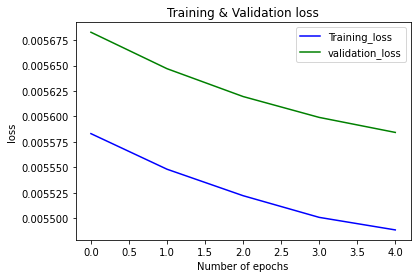

In [15]:
plot_result(total_train_loss, total_valid_loss, 'loss')

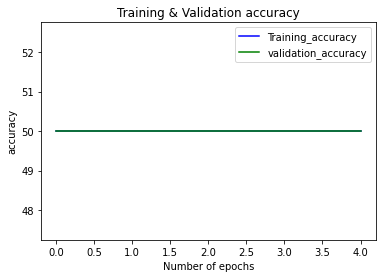

In [16]:
plot_result(total_train_accuracy, total_valid_accuracy, 'accuracy')